# lesson 10 inclass code practice

build a ancester class

Node: 
##forward: Function, how to calculate the inputs
##backward: Function, how to get the gradients of the nodes, when backpropagation
##gradients: mapper, the gradient of this node to its inputs node
##inputs: list, the inputs nodes of this node
##outputs: list, the outputs nodes of this node

# Object Oriented

In [40]:
import numpy as np

In [41]:
class Node:
    """
    Each node will have these attributions and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is anoprator of ax+b, its input will be x, and output will its successors, so the 
        inputs and outputs will be the connected nodes to the node
        """
        self.inputs = inputs
        self.outputs = []
        self.value = None
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self) #build connected relationship
            
    def forward(self):
        """
        compute the output value based on the input nodes
        """
        raise NotImplemented
        
    def backward(self):
        """
        compute the gradients of current note based on the input nodes
        """
        raise NotImplemented
           

In [42]:
class Input(Node):
    '''
    if the node is the operator of "ax + b"; see a , b , x both as a node object
    So this Input object is for feedding data to the layer.
    In order to make graph simple ,and casue it's fully connected network ,we can see one layer as as Node
    '''
    def __init__(self, name, inputs=[]):
        self.name = name
        super().__init__(inputs)
        
    def forward(self, value=None):
        if value:
            self.value = value
            
    def backward(self):
        self.gradients = {}
         #从输出节点中获取loss函数对该节点的偏导，而用该值乘该节点对input参数的导数即得到loss对input的导数
        #由此可见该节点可以得到loss对input的导数，这也是为什么该节点直接从output节点中获取loss函数对该节点的偏导
        for node in self.outputs:
            grad_cost = node.gradients[self]
            self.gradients[self] = grad_cost
            
    def __repr__(self):
        return "Input Node: {}".format(self.name)
        

In [43]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        '''
        nodes, weigths,bias is Input node object
        '''
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        super().__init__(inputs=[nodes, weights, bias])
        
    def forward(self):
        '''
        compute the a*x + b, In order to make it available for matric input ,
        we use numpy  to caculate    
        '''
        #print(self.x_node.value.shape, self.w_node.value.shape,'33333')
        self.value = np.dot(self.x_node.value, self.w_node.value.T) + self.b_node.value
        
    def backward(self):
        """
        linear function get gradients of nodes
        """
        for node in self.outputs:
            grad_cost = node.gradients[self]
            self.gradients[self] = grad_cost
            self.gradients[self.w_node] = np.dot(grad_cost.T, self.x_node.value)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value)
            self.gradients[self.b_node] = grad_cost

In [44]:
class Sigmoid(Node):
    def __init__(self, node):
        self.x_node = node
        super().__init__([node])
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
        
    def backward(self):
        y = self.value
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
            #不管是矩阵输入还是单个输入，self.partial都是一个一维常数，所以可以直接相乘
            self.gradients[self.x_node] = grad_cost * self.partial 

In [45]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        super().__init__(inputs=[y_true, y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean(self.diff ** 2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff
        

In [46]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [47]:
#单节点传播测试
#当输入数据变成矩阵时，相当于单节点就变成了layer
step1 = 3 * 4 + 2 
print(step1)
step2 = 1. / (1 + np.exp(-1* step1))
print(step2)
loss = (step2 - 0.3) ** 2
print(loss)

14
0.9999991684719722
0.4899988358614525


In [48]:
x = Input('x')
y = Input('y')
w = Input('w')
b = Input('b')
linear_output = Linear(x, w, b)
y_hat = Sigmoid(linear_output)
loss = MSE(y, y_hat)

In [49]:
x.value = np.array([3])
y.value = np.array([0.3])
w.value = np.array([4])
b.value = np.array([2])

In [50]:
linear_output.forward()
y_hat.forward()
loss.forward()

In [51]:
loss.backward()
y_hat.backward()
linear_output.backward()

In [53]:
print(linear_output.value, y_hat.value, loss.value)

[14] [0.99999917] 0.4899988358614525


In [74]:
def topological_sort(data_with_value):
    inputs_nodes = [n for n in data_with_value.keys()]
    nodes = inputs_nodes.copy()
    G= {}
    
    while len(nodes) > 0:
        n = nodes.pop(0) #广度优先搜索找出每个节点的in节点和out节点
        if n not in G:
            G[n] = {'in' : set(), 'out' : set()}
            for m in n.outputs:
                if m not in G:
                    G[m] = {'in' : set(), 'out' : set()}
                G[n]['out'].add(m)
                G[m]['in'].add(n)
                nodes.append(m)
                
    L = []
    S = set(inputs_nodes)
    while len(S) > 0:
        n = S.pop()
        L.append(n)
        for  m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) ==0:
                S.add(m)
    return L     

In [77]:
def topological_sort(data_with_value):
    input_nodes = [n for n in data_with_value.keys()]
    
    nodes = input_nodes.copy()
    G = {}
    while len(nodes) > 0:
        n = nodes.pop(0) #广度优先搜索找出每个节点的in节点和out节点
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
#         if isinstance(n, Input):
#             n.value = feed_dict[n] #feed orgin value, it's ok do it somewhere else        
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [70]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    '''
    因为我们要优化的是w和b这些参数矩阵，所以trainable_nodes就应该是这些参数代表的节点
    '''
    for t in trainable_nodes:
        step = -1 * learning_rate * t.gradients[t]
        t.value = t.value + step

In [56]:
from sklearn.datasets import load_boston

In [57]:
from sklearn.utils import resample

In [58]:
def feed_data(feed_dict):
    for key in feed_dict.keys():
        key.value = feed_dict[key]

In [82]:
data = load_boston()
X_ = data['data']
y_ = data['target']

X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden1 = 64 #隐藏层是64个节点
n_hidden2 = 64 #隐藏层是64个节点
n_out = 1

W1_, b1_ = np.random.randn(n_hidden1, n_features), np.zeros(n_hidden1)
W2_, b2_ = np.random.randn(n_hidden2, n_hidden1), np.zeros(n_hidden2)
W3_, b3_ = np.random.randn(1, n_hidden2), np.zeros(1)

# Input data. For the training data
X, y = Input(name='X'), Input(name='y')
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
W3, b3 = Input(name='W3'), Input(name='b3')

#network connection
linear_output1 = Linear(X, W1, b1)
sigmoid_output1 = Sigmoid(linear_output1)
linear_output2 = Linear(sigmoid_output1, W2, b2)
sigmoid_output2= Sigmoid(linear_output2)
yhat = Linear(sigmoid_output2, W3, b3)
loss = MSE(y, yhat)

# get topological sort, use this order to  compute Back propagation
input_node_with_value = {X:X_, y:y_, W1: W1_, W2: W2_, W3: W3_,b1: b1_, b2: b2_,b3: b3_}
graph = topological_sort(input_node_with_value)

#feed initial weight and bias of each layer
feed_dict = {W1 : W1_, W2:W2_, W3:W3_, b1:b1_, b2:b2_, b3:b3_}
feed_data(feed_dict)
print(len(W1.value), '1234')

losses =[]
epochs = 5000
batch_size = 96
step_per_epoch = X_.shape[0] // batch_size
learning_rate = 1e-2

for i in range(epochs):
    loss = 0
    for _step in range(step_per_epoch):
        #random choose data
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        feed_dict = {X:X_batch, y:y_batch}
        feed_data(feed_dict)
        #print(len(X.value), '111')
        
        training_one_batch(graph) #训练一次
        sgd_update(trainable_nodes = [W1, W2, W3, b1, b2, b3], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss / step_per_epoch))
        losses.append(loss)
        

64 1234
Epoch: 1, loss = 151.259
Epoch: 101, loss = 7.181
Epoch: 201, loss = 3.516
Epoch: 301, loss = 3.202
Epoch: 401, loss = 2.497
Epoch: 501, loss = 1.934
Epoch: 601, loss = 1.616
Epoch: 701, loss = 1.450
Epoch: 801, loss = 1.301
Epoch: 901, loss = 0.991
Epoch: 1001, loss = 0.984
Epoch: 1101, loss = 1.080
Epoch: 1201, loss = 0.867
Epoch: 1301, loss = 0.738
Epoch: 1401, loss = 0.887
Epoch: 1501, loss = 0.852
Epoch: 1601, loss = 0.749
Epoch: 1701, loss = 0.765
Epoch: 1801, loss = 0.562
Epoch: 1901, loss = 0.619
Epoch: 2001, loss = 0.662
Epoch: 2101, loss = 0.574
Epoch: 2201, loss = 0.534
Epoch: 2301, loss = 0.503
Epoch: 2401, loss = 0.498
Epoch: 2501, loss = 0.409
Epoch: 2601, loss = 0.439
Epoch: 2701, loss = 0.529
Epoch: 2801, loss = 0.386
Epoch: 2901, loss = 0.439
Epoch: 3001, loss = 0.405
Epoch: 3101, loss = 0.316
Epoch: 3201, loss = 0.296
Epoch: 3301, loss = 0.316
Epoch: 3401, loss = 0.334
Epoch: 3501, loss = 0.364
Epoch: 3601, loss = 0.327
Epoch: 3701, loss = 0.298
Epoch: 3801, l

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

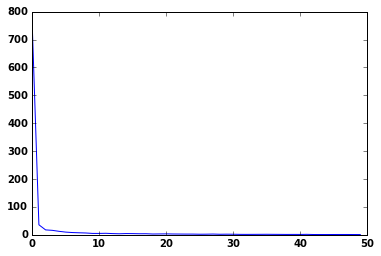

In [86]:
plt.plot(losses)

In [87]:
print(linear_output1.value.shape)
print(sigmoid_output1.value.shape)
print(linear_output2.value.shape)

(96, 64)
(96, 64)
(96, 64)


In [88]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

ImportError: No module named 'tensorflow'